<a href="https://colab.research.google.com/github/renaud-florquin/hands_on_AI/blob/master/Intro2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First NMIST classifier using fully connected NN and PyTorch

Reference: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [0]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

1.2.0
True


### hyperparameters

In [0]:
input_size = 784
output_size = 10

epochs = 100
batch_size = 50
learning_rate = 0.0005

### Train and test data loader

In [0]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,),(0.3081,))])

In [0]:
train_set = torchvision.datasets.MNIST('tmp/', download=True, train=True, transform=transform)
test_set = torchvision.datasets.MNIST('tmp/', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

Access to the train loader to see the data and format

In [0]:
train_iter = iter(train_loader)
x, y = train_iter.next()

In [20]:
x.shape, y.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

Display the label of the fist batch

In [24]:
print(y.reshape(batch_size//10, 10))

tensor([[3, 0, 0, 5, 9, 3, 5, 9, 5, 5],
        [0, 9, 4, 7, 8, 8, 9, 1, 1, 2],
        [7, 8, 0, 2, 7, 6, 9, 1, 5, 5],
        [5, 1, 8, 7, 9, 0, 5, 9, 0, 6],
        [1, 4, 7, 2, 5, 2, 1, 8, 1, 7]])


Display the x content (batch_size images of handwritten digits)

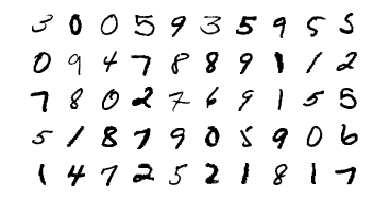

In [19]:
figure = plt.figure()

for index in range(batch_size):
    plt.subplot(6, 10, index+1)
    plt.axis('off')
    plt.imshow(x[index].numpy().squeeze(), cmap='gray_r')
plt.show()

### Neural network definition

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, output_size)
        
    def forward(self, x):
        z = x.view(-1, 1*28*28)
        z = self.layer1(z)
        z = F.relu(z)
        z = self.layer2(z)
        z = F.relu(z)
        z = self.layer3(z)
        return F.log_softmax(z)

In [29]:
net = Network()
print(net)

Network(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
)


Other solution: 

In [0]:
net = nn.Sequential(nn.Linear(input_size, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, output_size),
                      nn.LogSoftmax(dim=1))

### Optimizer and Loss function definition

In [0]:
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

### Train function

In [0]:
train_losses = []
test_losses = []
test_accuracies = []

def train_network(epoch):
    net.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        output = net(x)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    return loss


In [0]:
def print_info(epoch, loss):
    print('Train Epoch: {} \tLoss: {:.6f}'.format(
      epoch, loss.item()))
    train_losses.append(loss.item())

def save_model_state():
    torch.save(net.state_dict(), 'model.pth')
    torch.save(optimizer.state_dict(), 'optimizer.pth')

### Evaluation function

In [0]:
def test_network():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            output = net(x)
            test_loss += F.nll_loss(output, y, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(y.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(100. * correct / len(test_loader.dataset))
    print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))


### Train phase

In [0]:
for e in range(epochs):
        loss = train_network(e+1)
        test_network()
        #print_info(e+1, loss)
        save_model_state()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: 0.4124, Accuracy: 8898/10000 (88%)
Test set: Avg. loss: 0.3139, Accuracy: 9120/10000 (91%)
Test set: Avg. loss: 0.2765, Accuracy: 9211/10000 (92%)
Test set: Avg. loss: 0.2489, Accuracy: 9277/10000 (92%)
Test set: Avg. loss: 0.2263, Accuracy: 9343/10000 (93%)
Test set: Avg. loss: 0.2081, Accuracy: 9408/10000 (94%)
Test set: Avg. loss: 0.1911, Accuracy: 9436/10000 (94%)
Test set: Avg. loss: 0.1810, Accuracy: 9456/10000 (94%)
Test set: Avg. loss: 0.1667, Accuracy: 9505/10000 (95%)
Test set: Avg. loss: 0.1559, Accuracy: 9546/10000 (95%)
Test set: Avg. loss: 0.1483, Accuracy: 9562/10000 (95%)
Test set: Avg. loss: 0.1402, Accuracy: 9593/10000 (95%)
Test set: Avg. loss: 0.1332, Accuracy: 9615/10000 (96%)
Test set: Avg. loss: 0.1280, Accuracy: 9628/10000 (96%)
Test set: Avg. loss: 0.1226, Accuracy: 9637/10000 (96%)
Test set: Avg. loss: 0.1184, Accuracy: 9657/10000 (96%)
Test set: Avg. loss: 0.1147, Accuracy: 9660/10000 (96%)
Test set: Avg. loss: 0.1112, Accuracy: 9670/1000

### Display the evolution of the test accuracy

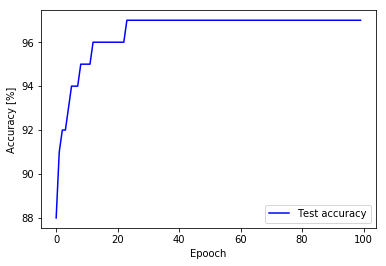

In [0]:
plt.plot(range(epochs), test_accuracies, color='blue')
plt.legend(['Test accuracy'], loc='lower right')
plt.xlabel('Epooch')
plt.ylabel('Accuracy [%]')

plt.show()